In [12]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

pd.options.display.max_colwidth = 100

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import requests

from os import listdir
import unicodedata

import json

from paths import *
from tools.vizu import remove_acentos
from tools.vizu import normalize_cols
from tools.io import read_sheets


from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')


# Brasil.IO

In [13]:
####### IMPORT DATA ######
url = 'https://brasil.io/api/dataset/covid19/caso/data?format=json'
df_final = pd.DataFrame()

while url != None:
    
    print(url)
    response = requests.get(url)
    data = response.text
    parsed = json.loads(data)
    url = parsed['next']
    df = pd.DataFrame(parsed['results']).sort_values(by='confirmed',ascending=False)
    df_final = pd.concat([df_final,df], axis=0)

https://brasil.io/api/dataset/covid19/caso/data?format=json
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=2
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=3


## transformation

In [14]:
from tools.manipulation import create_br_not_sp

df = df_final.sort_values(by='confirmed',ascending=False)
dd = create_br_not_sp(df)

### GET ONLY LAST DAY
mask = dd['date'] < today
dd = dd[mask]

dd = dd.sort_values(by=['date'],ascending=False)
dd = dd.sort_values(by=['confirmed'],ascending=False)

# get only the states
mask = ((dd['place_type']!='city'))
df_states = dd[mask]
df_states = df_states.sort_values(by=['date'],ascending=False)

# Import Data

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv')
df['state'] = df['state'].str.replace('TOTAL','BRASIL')
df.to_csv('brasil_states.csv', index=False)
dd = df.copy()

In [28]:
dd = dd.drop(['country','deaths'],1)

In [29]:
dd.tail(30)

,date,state,city,newCases,totalCases
451,2020-03-28,RR,TOTAL,0,12
452,2020-03-28,BRASIL,TOTAL,462,3935
453,2020-03-29,DF,TOTAL,29,289
454,2020-03-29,MG,TOTAL,26,231
455,2020-03-29,RS,TOTAL,26,226
456,2020-03-29,BA,TOTAL,27,154
457,2020-03-29,SP,TOTAL,45,1451
458,2020-03-29,MT,TOTAL,3,16
459,2020-03-29,RN,TOTAL,23,68
460,2020-03-29,RJ,TOTAL,42,600


## MYTABLE

In [30]:
from tools.io import read_sheets
df = read_sheets('covid19_estados')

In [31]:
ddf = pd.merge(dd , df, on=['date','state'], how='left')
ddf['confirmed'] = ddf['totalCases']
ddf['new_cases'] = ddf['newCases']
ddf = ddf.drop(['city','newCases','totalCases'],1)
df  = ddf.copy()

In [32]:
for col in ['confirmed','new_cases','deaths','new_deaths']:
    df[col] = pd.to_numeric(df[col])

In [33]:
df_states = df.sort_values(by=['date','confirmed'], ascending=False)
df_states['city'] = df_states['state']
df_states.head()

mask = (df_states['state']!='BRASIL') & (df_states['state']!='SP')
not_sp = df_states[mask].groupby(by=['date'], as_index=False).sum()

not_sp['state'] = 'EXCETO SP'
not_sp['city'] = 'EXCETO SP'
df_states = pd.concat([df_states,not_sp[df_states.columns]],axis=0)


In [34]:
df_states

,date,state,confirmed,new_cases,deaths,new_deaths,city
508,2020-03-29,BRASIL,4263,328,NaN,NaN,BRASIL
485,2020-03-29,SP,1451,45,NaN,NaN,SP
488,2020-03-29,RJ,600,42,NaN,NaN,RJ
496,2020-03-29,CE,348,26,NaN,NaN,CE
481,2020-03-29,DF,289,29,NaN,NaN,DF
482,2020-03-29,MG,231,26,NaN,NaN,MG
483,2020-03-29,RS,226,26,NaN,NaN,RS
492,2020-03-29,SC,194,10,NaN,NaN,SC
484,2020-03-29,BA,154,27,NaN,NaN,BA
491,2020-03-29,PR,148,11,NaN,NaN,PR


## VIS

In [21]:
from tools.vizu import brasil_vis
df_states = df_states.sort_values(by=['date'],ascending=False)

escala  = 'lin'
largura = None
save    = True
#### CHOSE CITIES TO START SELECTED IN GRAPH
in_cities = ['BRASIL','SP', 'RJ','EXCETO SP']

# mask = ((dd[var_col]>0))
# dd = dd[mask]

## confirmed or deaths
for var in ['deaths','confirmed']:
    fig = brasil_vis(df_states, var,in_cities, escala, today='25/03/2020', save=True)

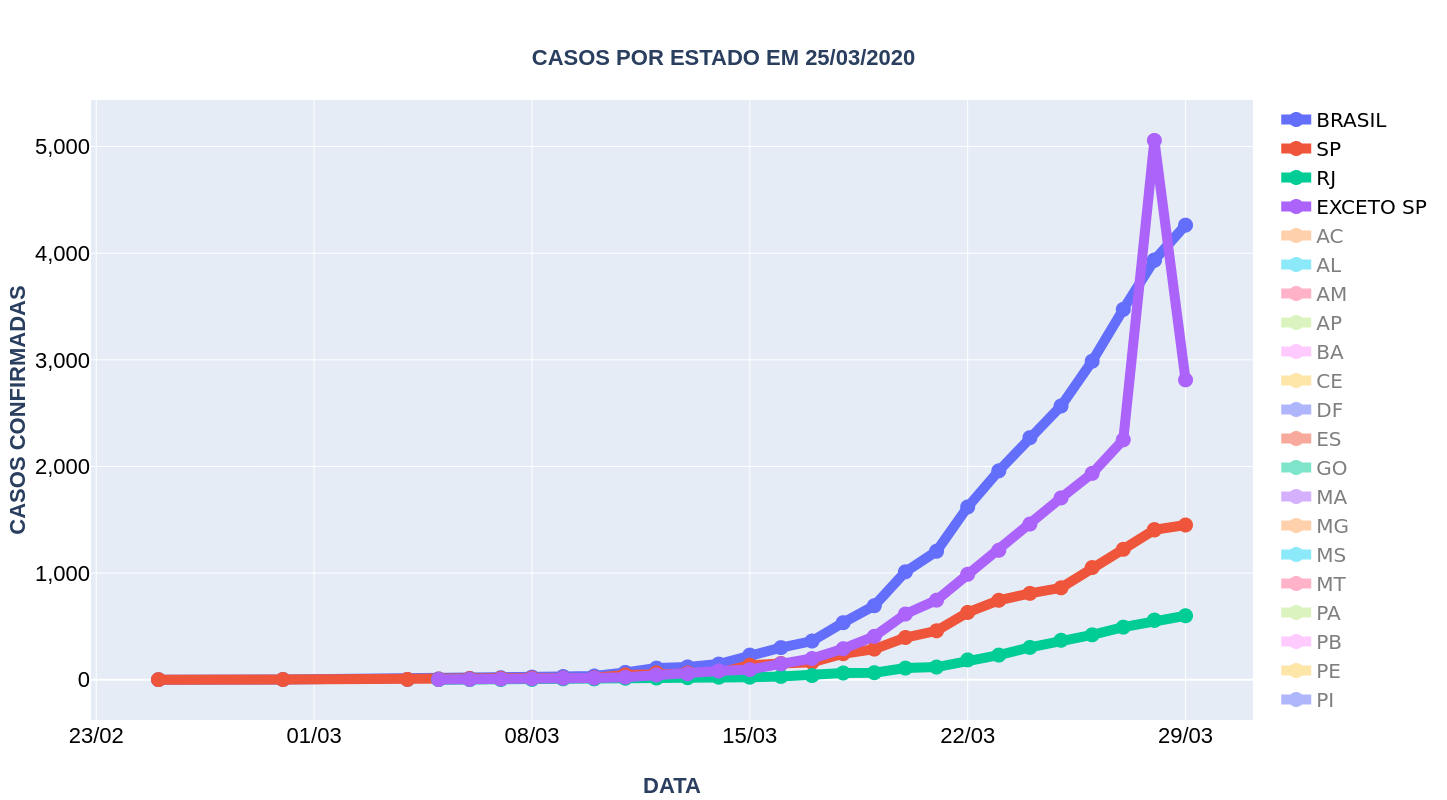

In [22]:
fig

In [70]:
# x = [0, 0, 3, 6, 76]
# y = ['0 a 9','10 a 19','20 a 39','40 a 59', '60+']

# df = pd.DataFrame(data=np.array([x,y]).T, columns=['obitos','faixa'])
# df.sort_values(by='obitos', ascending=False)

,obitos,faixa
4,76,60+
3,6,40 a 59
2,3,20 a 39
0,0,0 a 9
1,0,10 a 19


In [77]:


# title  = 'Óbitos por Faixa Etária'
# x_name = 'Óbitos'
# y_name = 'Faixa Etária'

# trace = go.Bar(
#     orientation='h',
#     x = df['obitos'],
#     y = df['faixa']
# )

# data = [trace]

# layout = go.Layout(
#     barmode='stack',
    
#     yaxis_title=y_name,
#     yaxis = dict(
#         tickfont=dict(
#             size=22,
#             color='black',
#         ),
#     ),
#     xaxis_title=x_name,
#     xaxis = dict(
#         tickfont=dict(
#             size=22,
#             color='black',
#         ),
# #         font = dict(size=20)

#     ),
    
#     font=dict(
#             size=25,
#         ),

#     width  = 800,
#     height = 800,
# )

# fig = go.Figure(data=data, layout=layout)
# fig